# БИХ-фильтры

Рассмотрим примеры применения БИХ-фильтров.

### Денойзер

Сначала рассмотрим применения денойзера.

Подгрузим библиотеки, сигнал и методы для рисования графиков.

In [1]:
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
import IPython

fs, data = wavfile.read('source/LetsGo.wav')
data = data/np.max(data)

C:\Users\aleksandr\AppData\Local\Temp\1\ipykernel_22048\3301881100.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('source/LetsGo.wav')


In [2]:
def myDFT_AmplPlot(t, x, N=512, fs = False, xLim = 0.5):
    
    if len(x)>512:
        N = len(x)
        
    xFFT = fftshift(fft(x, N))
    # Амплитуда спектра
    xA = np.abs(xFFT)

    xList = [x, xA]
    titles = ['Сигнал', 'Спектр']

    # Графики
    plt.figure(figsize=(12, 6))
    for i, sig in enumerate(xList):
        plt.subplot(2, 2, i+1)
        plt.title(titles[i])
        if i == 0:
            plt.plot(t, sig)
            plt.xlabel('Временные отсчёты')
            #plt.xlim([-0.25, len(x)-0.75])
        else:
            if fs == False:
                plt.plot(np.arange(-np.floor(N/2), np.floor((N+1)/2))/N,sig)
                plt.xlabel('Частотные отсчёты')
                plt.xlim([0, xLim])
                plt.xticks(np.linspace(0, xLim, 11))
            else:
                plt.plot(fs*np.arange(-np.floor(N/2), np.floor((N+1)/2))/N,sig)
                plt.xlabel('Частоты')
                plt.xlim([0, fs*xLim])
                plt.xticks(np.linspace(0, fs*xLim, 11))
        plt.grid()
    plt.tight_layout()
    
    
def plot_response(w, h, fs, title):
    plt.figure(figsize=(5,2))
    plt.plot(w, 10*np.log10(np.abs(h)))
    plt.ylim(-40, 5)
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда (дБ)')
    plt.title(title)
    

Чтобы шум был слышим, добавим его в виде тона на 500 Гц.

In [3]:
noise_freq = 500
t = np.arange(0,len(data)) / fs

noise = np.sin(2*np.pi*noise_freq*t)
y_noised = data + 0.75*noise

IPython.display.Audio(y_noised, rate=fs)

In [4]:
r=0.999
c0=2*np.cos(2*np.pi*noise_freq/fs)
af = np.array([1, - r*c0, r**2])
bf = np.array([1, -c0, 1])
print(af)
print(bf)

[ 1.         -1.99293238  0.998001  ]
[ 1.        -1.9949273  1.       ]


(0.0, 882.0)

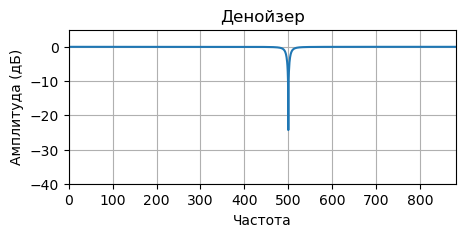

In [5]:
w, h = signal.freqz(bf, af, worN=2**15, fs=fs)

plot_response(w, h, fs, "Денойзер")
plt.xlim(0,0.02*fs)

In [6]:
y_filt = signal.lfilter(bf, af, np.float16(y_noised))
IPython.display.Audio(y_filt, rate=fs)

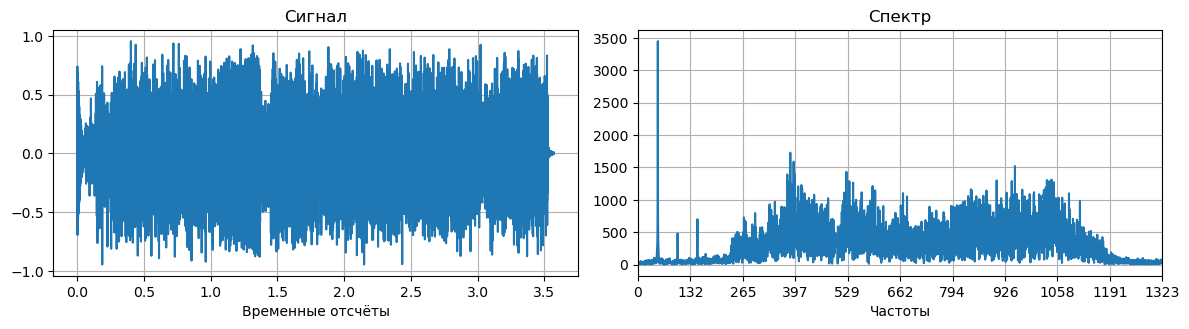

In [7]:
myDFT_AmplPlot(t, y_filt, fs = fs, xLim=0.03)

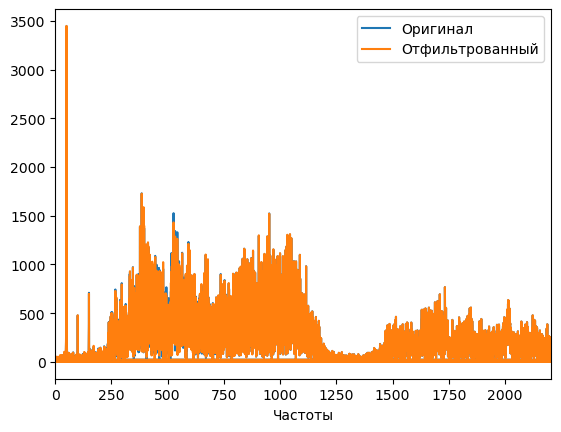

In [8]:
yFFT = np.abs(fft(y_filt))
dataFFT = np.abs(fft(data))
N = len(yFFT)
sig = np.array([dataFFT, yFFT]).T
t= np.arange(N)*fs/N

plt.plot(t,sig)
plt.xlabel('Частоты')
plt.xlim([0, fs*0.05])
plt.legend(["Оригинал","Отфильтрованный"])

In [9]:
def mySNR(sig,noise):
    return 10*np.log10(np.sum(np.abs(sig)**2)/np.sum(np.abs(noise)**2))

In [10]:
print('SNR для зашумлённого сигнала: ', mySNR(data, y_noised))
print('SNR для очищенного сигнала: ', mySNR(data, y_filt-data))

SNR для зашумлённого сигнала:  -6.490618711882402
SNR для очищенного сигнала:  15.858773943345227


### Фильтр Карплюса-Стронга

Реализуем фильтр Карплюса-Стронга

In [18]:
from random import random
from scipy.io.wavfile import write
from scipy.signal import lfilter, freqz

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# создание фильтра КС
def get_KS_filter(M, alpha):
    b = np.array([1]) 
    a = np.array([1] + ([0]*(M-1)) + [-alpha]) 
    return b,a   

Выведем его АЧХ.

882.0


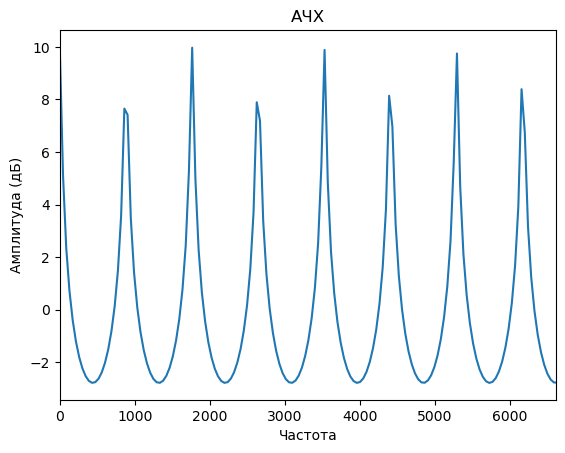

In [19]:
fs = 44100
M = 50
alpha = 0.9
b,a = get_KS_filter(M, alpha)

# График АЧХ
w,h = signal.freqz(b,a,fs=fs)
plt.plot(w, 10 * np.log10(abs(h)))
plt.xlim(0,0.15*fs)
plt.ylabel('Амплитуда (дБ)')

plt.xlabel('Частота')

plt.title('АЧХ')

print(fs/M)

### Задача

Напишите код для генерации звучания ноты по заданной частоте в герцах и длительности в секундах с помощью фильтра Карплюса-Стронга. 

In [60]:
def get_note(freq, dur, fs):    
    alpha = 1
    M = int(fs / freq)
    b,a = get_KS_filter(M, alpha)
    x = np.hstack([np.sin(np.linspace(0, 1, M)), np.zeros((int(fs*dur) - M))])    
    sig = signal.lfilter(b, a, np.float16(x))
    return sig 

In [69]:
dur = 20
A = get_note(440, dur, fs)
print(fs, A.shape, M)
display.Audio(A, rate=44100, embed=True)

44100 (882000,) 3


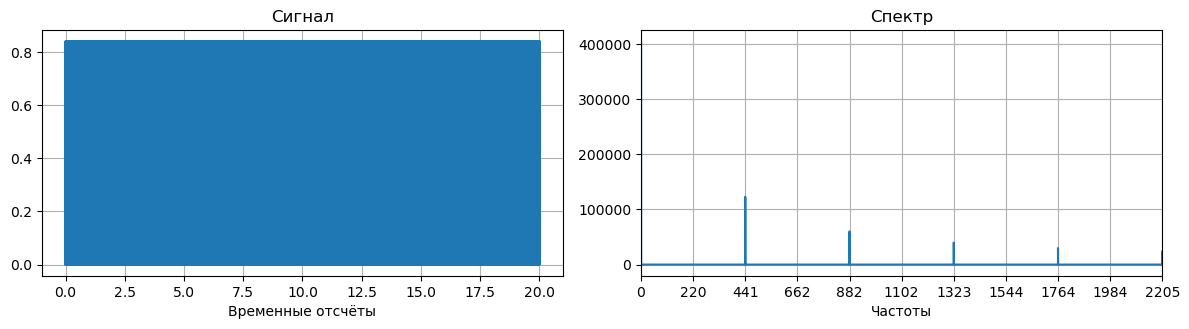

In [70]:
t = np.linspace(0, dur, fs*dur)
myDFT_AmplPlot(t, E, fs = fs, xLim=0.05)
#plt.ylim([0, 10000])

Далее, для формирования мелодии по списку нот (или частот) удобно написать специальный метод:

In [71]:
def get_melody(melody, fs):
    dur = 0.5
    x = []
    for note in melody:
        x = x + list(get_note(note, dur, fs))        
    
    return np.array(x)

Сформируем некоторую мелодию.

In [72]:
notes = ['A', 'A#', 'Bb', 'B', 'C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'F', 'F#', 'Gb', 'G', 'G#', 'Ab']
valueSet = [0,1,1,2,3,4,4,5,6,6,7,8,9,9,10,11,11]

noteDict = dict(zip(notes, valueSet))

song = ['A','A','E','E' ,'F#' ,'F#','E', 'E', 'D','D', 'C#','C#','B','B','A']

melody = [440 * 2 ** (noteDict[note]/12) for note in song]

In [73]:
x = get_melody(melody, fs)

display.Audio(x, rate=44100, embed=True)

Добавим несколько эффектов.

In [74]:
fs_filt, filt = wavfile.read('source/impulse_cathedral.wav')
y = signal.lfilter(np.float16(filt), [1], np.float16(x))
IPython.display.Audio(y, rate=fs)

Добавим небольшой эффект эха.

In [75]:
# формирование фильтра
filt = np.zeros(np.int16(0.1*fs))
filt[0] = 1
filt[np.int16(len(filt)/2)] = 1.2
filt[-1] = 0.6

y2 = signal.lfilter(np.float16(filt), [1], y)
IPython.display.Audio(y2, rate=fs)

Можно сверху применить ещё какой-нибудь фильтр, например, фильтр Баттерворта, для приглушения высоких частот.

In [76]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [77]:
b, a = signal.butter(5, 1000, 'low', fs = fs)
w, h = signal.freqz(b, a, fs=44100)
print(b)
print(a)

[1.46896340e-06 7.34481698e-06 1.46896340e-05 1.46896340e-05
 7.34481698e-06 1.46896340e-06]
[ 1.         -4.53905152  8.26066093 -7.53334038  3.44208742 -0.63030945]


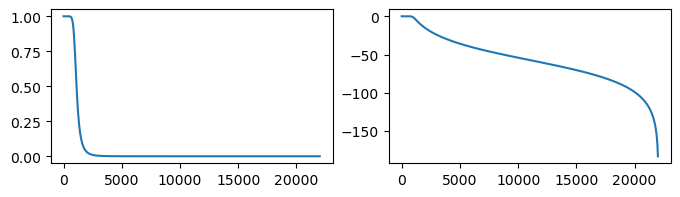

In [78]:
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.plot(w,abs(h))
plt.subplot(122)
plt.plot(w, 10 * np.log10(abs(h)))

In [79]:
y3 = signal.lfilter(b, a, y2)
IPython.display.Audio(y3, rate=fs)

In [80]:
def wave(fs,samples,name="melody") :
    scaled = np.int16(samples/np.max(np.abs(samples)) * 32767)
    write(name+'.wav', fs, scaled)
     
filename = "LittleStar"
wave(fs, y3, filename)

# Фазовый сдвиг

Продемонстрируем также эффект фазовой задержки сигнала на примере.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
import IPython

def plot_response(w, h, fs, title):
    plt.figure(figsize=(5,2))
    plt.plot(w, 10*np.log10(np.abs(h)))
    plt.ylim(-40, 5)
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда (дБ)')
    plt.title(title)

Сформируем синусоиду с шумом.

In [82]:
w1 = 10  ## частота синуса
a1 = 1   ## амплитуда синуса
alpha = 0.2 ## амплитуда шума
Fs = 8000  ## частота дискретизации
Ts = 1.0/Fs ## интервал времени между соседними точками

t = np.arange(0, 1, Ts)
## cигнал из трёх компонент
y = a1*np.sin(2*np.pi*w1*t)

N = len(t) 
#np.random.seed(42)
## добавляем шум в данные
y_noise = y + alpha*np.random.randn(N)

Рассмотрим простой фильтр скользящего среднего.

(0.0, 400.0)

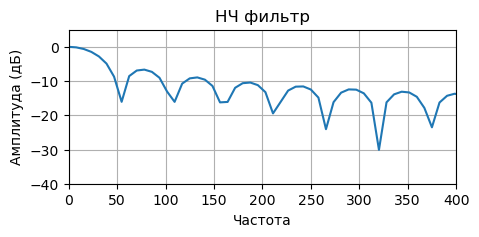

In [83]:
lp_filter = np.ones(150)/150

w, h = signal.freqz(lp_filter, [1], fs=Fs)
plot_response(w,h,Fs,"НЧ фильтр")
plt.xlim(0, 0.05*Fs)

Проведём фильтрацию.

In [84]:
y_filt = signal.lfilter(lp_filter, [1], y_noise)

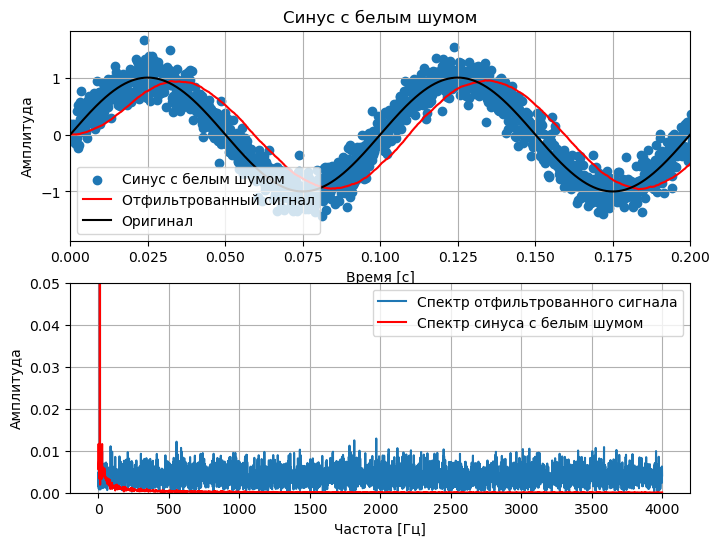

In [85]:
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)[range(int(N/2))]
## делаем преобразование Фурье cигнала с шумом
Y = 2/N * np.fft.fft(y_noise)[range(int(N/2))]
## делаем преобразование Фурье отфильтрованного cигнала
Y_filt = 2/N * np.fft.fft(y_filt)[range(int(N/2))]

## рисуем графики
f, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].scatter(t, y_noise)
ax[0].plot(t, y_filt, c='r')
ax[0].plot(t, y, c='k')
ax[0].set_xlim([0, 0.2])
ax[0].set_ylabel('Амплитуда')
ax[0].set_xlabel('Время [c]')
ax[0].set_title('Cинус с белым шумом')
ax[0].legend(['Cинус с белым шумом','Отфильтрованный сигнал', 'Оригинал'])
ax[0].grid()

ax[1].plot(frq, abs(Y))
ax[1].plot(frq, abs(Y_filt), c='r')
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
# ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 0.05])
ax[1].legend(['Cпектр отфильтрованного сигнала', 'Спектр синуса с белым шумом'])
ax[1].grid()

Как видно из графика, отфильтрованный сигнал действительно имеет некоторую задержку относительно исходной синусоиды.

Метод `y = signal.lfilter(b,[1],x)` реализован по формуле

$$y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M] $$

Причём для вычисления $y[0]$ используются по умолчанию нулевые отсчёты $x[-M], ..., x[-1]$.


Задержки можно избежать при использовании метода `signal.filtfilt`.

In [86]:
lp_filter2 = np.ones(150)/150
y_filt2 = signal.filtfilt(lp_filter2, [1], y_noise, padlen=150)

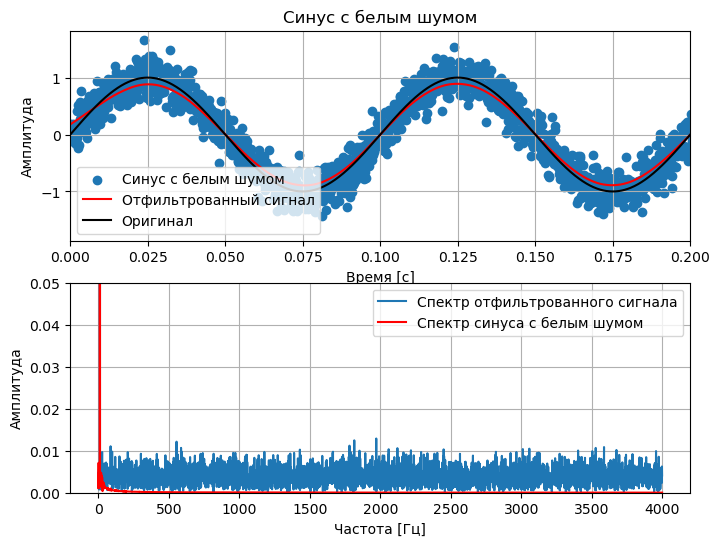

In [87]:
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)[range(int(N/2))]
## делаем преобразование Фурье cигнала с шумом
Y = 2/N * np.fft.fft(y_noise)[range(int(N/2))]
## делаем преобразование Фурье отфильтрованного cигнала
Y_filt2 = 2/N * np.fft.fft(y_filt2)[range(int(N/2))]

## визуализируем ряд
f, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].scatter(t, y_noise)
ax[0].plot(t, y_filt2, c='r')
ax[0].plot(t, y, c='k')
ax[0].set_xlim([0, 0.2])
ax[0].set_ylabel('Амплитуда')
ax[0].set_xlabel('Время [c]')
ax[0].set_title('Cинус с белым шумом')
ax[0].legend(['Cинус с белым шумом','Отфильтрованный сигнал', 'Оригинал'])
ax[0].grid()

ax[1].plot(frq, abs(Y))
ax[1].plot(frq, abs(Y_filt2), c='r')
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
# ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 0.05])
ax[1].legend(['Cпектр отфильтрованного сигнала', 'Спектр синуса с белым шумом'])
ax[1].grid()